In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pickle
from tabulate import tabulate
from functools import partial
import ctypes
from scipy.optimize import minimize, LinearConstraint, dual_annealing, Bounds, NonlinearConstraint
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt 
import multiprocessing, tqdm
from bgspy.likelihood import negll_c, negll, negll_numba, negll_fixmu_c
from bgspy.likelihood import negll_fixmu_numba, negll_free_c, negll_free_numba
from bgspy.likelihood import bounds_simplex, random_start_simplex, random_start_mutation, negll_mutation, bounds_mutation

In [264]:
def nloptim_summary(run_res, nt, nf, nll=None):
    nlls, thetas, _ = run_res
    rank = np.argsort(nlls)
    best_idx = rank[0]
    theta = thetas[best_idx]
    nll = nlls[best_idx]
    print(f"NLL: {nll}\npi0: {theta[0]}\n")
    print(f"μ: {theta[1]}\nW = ")
    W = theta[2:].reshape((nt, nf))
    print(tabulate(np.round(W, 3)))
    print(f"sums: {W.sum(axis=0)}")
    return theta

def optim_summary(res, nt, nf):
    theta = res.x
    print(f"NLL: {res.fun}\npi0: {theta[0]}\n")
    offset = theta.size - nt * nf 
    if offset == 2:
        print(f"μ: {theta[1]}\nW = ")
    
    W = theta[offset:].reshape((nt, nf))
    print(tabulate(np.round(W, 3)))
    print(f"sums: {W.sum(axis=0)}")

def check_bounds(x, lb, ub):
    assert np.all((x >= lb) & (x <= ub))

## Load data and define some functions

In [153]:
dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
B, Bp, Y, w = dat['B'], dat['Bp'], dat['Y'], dat['w']

nx, nw, nt, nf = B.shape
nparams = nt * nf + 2

In [209]:
def optim_plot(tail=0.5, **runs):
    fig, ax = plt.subplots()
    for key, run in runs.items():
        nll = run[0]
        succ = run[2]
        q = np.quantile(nll, tail)
        x = nll[nll < q]
        ax.scatter(np.arange(len(x)), np.sort(x)[::-1], s=1, label=key, c=succ[nll < q])
    ax.legend()

## SciPy Minimize on Reduced Features Model

Here we try the simplest case: only one column of features (CDS) of the test human data.

In [5]:
def negll_mutation(Y, B, w):
    def func(theta):
        return negll_c(theta, Y, B, w)
    return func

def run_optims(workerfunc, startfunc, nstarts, ncores = 50):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x.fun for x in res])
    thetas = np.array([x.x for x in res])
    success = np.array([x.success for x in res])
    return nlls, thetas, success
    

In [41]:
nllBp = negll_mutation(Y, Bp[..., 0][..., None], w)
nllB = negll_mutation(Y, B[..., 0][..., None], w)


def worker_Bp_reduced(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

def worker_B_reduced(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

resB = run_optims(worker_B_reduced, partial(random_start_mutation, nt, 1), 1000)
resBp = run_optims(worker_Bp_reduced, partial(random_start_mutation, nt, 1), 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.92it/s]


In [21]:
def summarize_optims(res):
    nlls, thetas, success = res
    x = thetas[np.argmin(nlls)]
    ll = np.min(nlls) / 1e11
    pi0 = x[0]
    w = x[1:]/x[1:].sum()
    print(f"neg loglik (x1e11) = {ll}\nπ0 = {pi0}\nw = {w}\n")

summarize_optims(resB)
summarize_optims(resBp)

neg loglik (x1e11) = 9.13679930680697
π0 = 0.0018476304665028685
w = [0.0018798  0.01466713 0.11731538 0.18781869 0.67831899]

neg loglik (x1e11) = 9.136510519023826
π0 = 0.0018618988022671547
w = [0.81998263 0.00712955 0.00712955 0.01275834 0.15299993]



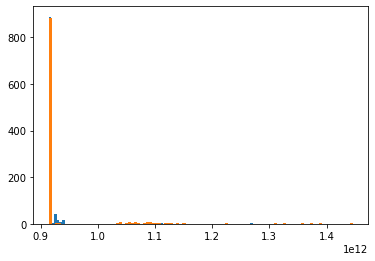

In [44]:
_ = plt.hist(resB[0], 100)
_ = plt.hist(resBp[0], 100)
#plt.xlim(9e11, 9.7e11)

In [ ]:

optim_plot(B=resB[0], Bp=resBp[0], tail=0.7)
plt.semilogy()

## Full Feature Model

In [71]:
nllBp = negll_mutation(Y, Bp, w)
nllB = negll_mutation(Y, B, w)

resB = run_optims(funcB, partial(random_start_mutation, nt, nf), 10000)
resBp = run_optims(funcBp, partial(random_start_mutation, nt, nf), 10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [57:46<00:00,  2.88it/s]


In [49]:
summarize_optims(resB)
summarize_optims(resBp)

neg loglik (x1e11) = 9.136238718763842
π0 = 0.0018680522258483635
w = [0.00092194 0.00871072 0.00092194 0.00092194 0.02331962 0.01110999
 0.03907131 0.03123646 0.06802779 0.05731969 0.11204503 0.11452544
 0.26444021 0.14045037 0.12697754]

neg loglik (x1e11) = 9.135727974098398
π0 = 0.0018471586635901594
w = [2.85181146e-01 3.03553277e-01 3.02736991e-01 1.48147813e-03
 1.96688018e-03 1.48860647e-04 1.48147813e-03 2.20764496e-03
 1.49313382e-04 2.22699421e-03 1.01987551e-02 1.88873906e-02
 3.26720335e-02 1.74235893e-02 1.96841676e-02]



In [72]:
summarize_optims(resB)
summarize_optims(resBp)

neg loglik (x1e11) = 9.136210620108592
π0 = 0.001832632938462439
w = [0.00067024 0.00303245 0.00356283 0.00225789 0.01622741 0.01293601
 0.03748141 0.02001501 0.01556434 0.05943573 0.02536378 0.02063053
 0.06551823 0.15102776 0.56627639]

neg loglik (x1e11) = 9.135631495158481
π0 = 0.0018756643233880147
w = [0.27265551 0.30606669 0.30738128 0.00197195 0.00041798 0.00243373
 0.00197195 0.00043947 0.00276012 0.00349522 0.00982398 0.01224425
 0.03734932 0.02431335 0.01667519]



[]

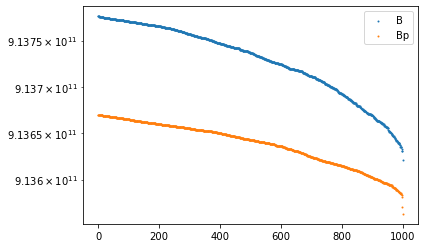

In [75]:
optim_plot(B=resB[0], Bp=resBp[0], tail=0.10)
plt.semilogy()

In [76]:
nlls, thetas, _ = resBp
x = thetas[np.argsort(nlls)[0]][1:].reshape((nt, nf))
np.round(x / x.sum(axis=0), 3)

array([[0.859, 0.897, 0.9  ],
       [0.006, 0.001, 0.007],
       [0.006, 0.001, 0.008],
       [0.011, 0.029, 0.036],
       [0.118, 0.071, 0.049]])

In [78]:
nlls, thetas, _ = resBp
x = thetas[np.argsort(nlls)[2]][1:].reshape((nt, nf))
np.round(x / x.sum(axis=0), 3)

array([[0.915, 0.753, 0.948],
       [0.   , 0.004, 0.   ],
       [0.   , 0.007, 0.   ],
       [0.   , 0.102, 0.02 ],
       [0.084, 0.133, 0.031]])

## Simplex Model

The simplex model is an $n_t \times n_f$ matrix $\mathbf{W}$ which are DFE weights (columns sum to 1). The mutation rate per selection class, per feature class is then $\mu \mathbf{W}$.

The bounds of $\mathbf{W}$ are $[0, 1]$, and the constraint is $\sum_j w_{i,j} = 1$ However, there is also a total mutation bound, $\mu_l \le \mu \le \mu_u$. So, 

$$ \mu_l \le \mu \mathbf{W} \le \mu_u$$

In [8]:
def negll_simplex(Y, B, w):
    def func(theta):
        new_theta = np.empty(theta.size - 1)
        new_theta[0] = theta[0]
        mu = theta[1]
        assert 1e-11 <= mu <= 1e-7, f"out of bounds! x={mu}"
        new_theta[1:] = mu*theta[2:]
        #assert np.all(1e-11 <= new_theta[1:])
        assert np.all(new_theta[1:] <= 1e-7)
        return negll_c(new_theta, Y, B, w)
    return func

def constraint_matrix(nt, nf):
    nparams = nt*nf + 2
    A = np.zeros((nf, nparams))
    for i in range(nf):
        start = 2 + i*nt
        W = A[i, 2:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def tol_vectors(n, tol1, tol2=None):
    if tol2 is None:
        tol2 = tol1
    return np.ones(n) - tol1, np.ones(n) + tol2

lb, ub = tol_vectors(nf, 1e-2)
A = constraint_matrix(nt, nf)
W_simplex_constraint = LinearConstraint(A, lb, ub)



A = constraint_matrix(nt, nf)

In [249]:
nllBp_simplex = negll_simplex(Y, Bp, w)
nllB_simplex = negll_simplex(Y, B, w)

tol = 1e-5
cons = tuple({'type': 'eq','fun': lambda x: np.abs((x[1] * np.sum(A[i, :].dot(x)) - 1) - tol)} for i in range(3))

def worker_simplex_Bp(start):
    return minimize(nllBp_simplex, x0=start, bounds=Bounds(*bounds_simplex(nt, nf)),
                    constraints=LinearConstraint(cons,  1e-11, 1e-7), method='SLSQP')

def worker_simplex_B(start):
    return minimize(nllB_simplex, x0=start, bounds=Bounds(*bounds_simplex(nt, nf)),
                    constraints=LinearConstraint(cons,  1e-11, 1e-7), method='SLSQP')

#resB_simplex = run_optims(worker_simplex_B, partial(random_start_simplex, nt, nf), 100)
#resBp_simplex = run_optims(worker_simplex_Bp, partial(random_start_simplex, nt, nf), 100)

## NonLinear Constraints

In [200]:
def negll_nlopt(Y, B, w):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        new_theta = np.empty(x.size - 1)
        new_theta[0] = x[0]
        mu = x[1]
        #assert 1e-11 <= mu <= 1e-7, f"out of bounds! x={mu}"
        new_theta[1:] = mu*x[2:]
        #assert np.all(1e-11 <= new_theta[1:])
        #assert np.all(new_theta[1:] <= 1e-7)
        return negll_c(new_theta, Y, B, w)
    return func


def run_nloptims(workerfunc, startfunc, nstarts, ncores = 50):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x[0] for x in res])
    thetas = np.array([x[1] for x in res])
    success = np.array([x[2] for x in res])
    return nlls, thetas, success
    

In [248]:



def inequality_constraint_functions(nt, nf, log10_mu_bounds=(-11, -7)):
    """
     l < u W < u
     l - uW < 0
     u W - u < 0
    """
    A = constraint_matrix(nt, nf)
    lower, upper = 10**log10_mu_bounds[0], 10**log10_mu_bounds[1]
    def func_l(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function(nt, nf):
    A = constraint_matrix(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func

hl, hu = inequality_constraint_functions(nt, nf)
ce = equality_constraint_function(nt, nf)
# NOTE: we do not have a start-based test of these bounds
# because it looks like SWIG's interface to NLOPT wraps this in a 
# weird way

In [249]:
opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
nll = negll_nlopt(Y, Bp, w)
opt.set_min_objective(nll) 

tols = np.repeat(1e-12, nf)
opt.add_inequality_mconstraint(hl, tols)
opt.add_inequality_mconstraint(hu, tols)
opt.add_equality_mconstraint(ce, tols)


lb, ub = bounds_simplex(nt, nf)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [291]:
random_start_simplex(nt, nf)

array([2.75395015e-04, 8.44491799e-08, 2.95879416e-01, 3.54000271e-02,
       6.59351376e-01, 4.33353421e-02, 4.30559707e-01, 9.75402550e-02,
       3.11119352e-01, 2.02464224e-01, 5.17237198e-02, 1.58390963e-01,
       3.00553663e-01, 5.04477512e-03, 1.91274928e-01, 3.10223789e-02,
       1.86339874e-01])

In [250]:
#opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-02] * nt*nf))
opt.set_ftol_abs(1e8)
#opt.set_stopval(923543002497)
opt.set_maxeval(100000)
x = random_start_simplex(nt, nf)
assert x.size == nparams

res = opt.optimize(x)

In [ ]:
def nlopt_worker(start, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = constraint_function(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-016] * nt*nf))
    #opt.set_ftol_abs(1e8)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(100000)
    x = random_start_simplex(nt, nf)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success



worker = partial(nlopt_worker, nt=nt, nf=nf) 
worker(random_start_simplex(nt, nf))
run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), 10_000)

 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 2950/10000 [05:53<1:17:14,  1.52it/s]

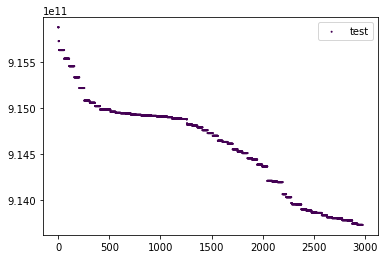

In [352]:
optim_plot(test=run_res, tail=0.6)

In [353]:
best_theta = nloptim_summary(run_res, nt, nf)

NLL: 913735030051.1781
pi0: 0.0019014653250919982

μ: 1.5020269730279135e-08
W = 
-----  -----  -----
0.796  0.76   0.145
0      0.066  0.012
0      0.034  0.042
0.142  0.033  0.056
0.062  0.107  0.745
-----  -----  -----
sums: [1. 1. 1.]


In [260]:
nloptim_summary(run_res, nt, nf) #old

NLL: 913681155492.8102
pi0: 0.0018981799738484477

μ: 3.80562102716475e-08
W = 
-----  -----  -----
0.962  0.777  0.97
0      0      0
0      0.037  0
0      0      0.048
0.038  0.223  0.03
-----  -----  -----
sums: [1.         1.03734706 1.04814817]


In [354]:
from scipy.stats import truncnorm

def trunc_normal(loc, scale, lower, upper):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return np.random.normal(loc, scale)
    return truncnorm.rvs(a, b)

def perturber(theta, log10_pi0_bounds=(-4, -3),
            log10_mu_bounds=(-11, -7), pi0_scale=1e-5, 
            mu_scale=1e-10, dfe_scale=1e-03):
    def func():
        new_theta = np.copy(theta)
        normal = truncnorm.rvs

        new_theta[0] = trunc_normal(theta[0], pi0_scale, 10**log10_pi0_bounds[0], 10**log10_pi0_bounds[1])
        new_theta[1] = trunc_normal(theta[1], mu_scale, 10**log10_mu_bounds[0], 10**log10_mu_bounds[1])
        for i in range(2, theta.size):
            w = theta[i]
            new_theta[i] = trunc_normal(w, dfe_scale, 10**log10_mu_bounds[0]/w, 10**log10_mu_bounds[1]/w)
        return new_theta
    return func

In [358]:
perturb_starts = perturber(best_theta)
run_res = run_nloptims(worker, perturb_starts, 4000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:43<00:00, 92.45it/s]


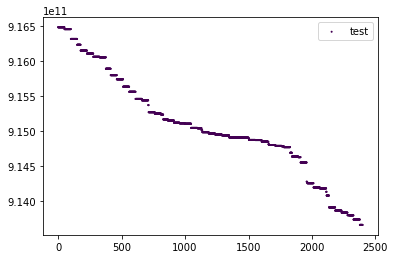

In [359]:
optim_plot(test=run_res, tail=0.6)

In [360]:
best_theta = nloptim_summary(run_res, nt, nf)

NLL: 913662075443.7277
pi0: 0.0017764274472884085

μ: 5.428821512378273e-09
W = 
-----  -----  -----
0.491  0.091  0.724
0.018  0.205  0.069
0.099  0.02   0.084
0.001  0.073  0.054
0.39   0.611  0.07
-----  -----  -----
sums: [1. 1. 1.]
